О сервисе «СберАвтоподписка»  
«СберАвтоподписка» предлагает новый для российского рынка способ
владения автомобилем и выступает в качестве альтернативы автокредиту.
Машина — это актив, который быстро теряет в цене, поэтому мы
рекомендуем вкладывать собственные средства в финансовые инструменты,
а автомобиль брать во временное пользование за комфортную сумму
в месяц.

#### Задача 

  - изучить предоставленный датасет,
  - ответить на вопросы из общей части (подразумевающей базовую обработку данных и их разведочный анализ)  
  - выполнить задание по специализации ML-инженер.

#### План работы 

1. Подготовительная часть
   - ознакомление с предоставленным датасетом и описание атрбиутов
   - оценка и описательные статистики данных
   - приведение данных к нормальному виду для дальнейшей работы
2. Разведочный анализ данных
   - базова чистка- проверка на дубликаты, пустые значения, типизация данных,
     ненужные атрибуты
   - распределения ключевых атрибутов и их отношение
3. Задание
   - предсказать cовершение целевого действия(ROC_AUC~0.65) - факт совершения
     пользователем целевого действия
   - упаковать модель в сервис, который будет брать на вход все атрибуты, типа utm_\*, devace_\*, geo_\*,
     и отдавать на выход 0/1(1-совершит любое целевое деиствие)




#### Описание представленных данных

GA Hits (ga_hits.pkI)  
*Одна строка = одно событие в рамках одного визита на сайт*  

Описание атрибутов:  

•	session _id — ID визита   
•	hit_date — дата события  
•	hlt_time — время события  
•	hit_number — порядковый номер события в рамках сессии  
•	hit_type — тип события  
•	hit_referer — источник события  
•	hit_page_path — страница события  
•	event_category — тип действия  
•	event_action — действие  
•	event_label — тег действия  
•	event_value — значения результата действия  

#### Импорт пакетов

In [1]:
import pandas as pd
import random

import matplotlib.pyplot as plt
import seaborn as sns

from  datetime import datetime


### Загрузка данных из файла

In [2]:
df_hits = pd.read_csv('data/ga_hits.csv', low_memory=False)
df_hits.head()

,session_id,hit_date,hit_time,hit_number,hit_type,hit_referer,hit_page_path,event_category,event_action,event_label,event_value
0,5639623078712724064.1640254056.1640254056,2021-12-23,597864.0,30,event,NaN,sberauto.com/cars?utm_source_initial=google&ut...,quiz,quiz_show,NaN,NaN
1,7750352294969115059.1640271109.1640271109,2021-12-23,597331.0,41,event,NaN,sberauto.com/cars/fiat?city=1&city=18&rental_c...,quiz,quiz_show,NaN,NaN
2,885342191847998240.1640235807.1640235807,2021-12-23,796252.0,49,event,NaN,sberauto.com/cars/all/volkswagen/polo/e994838f...,quiz,quiz_show,NaN,NaN
3,142526202120934167.1640211014.1640211014,2021-12-23,934292.0,46,event,NaN,sberauto.com/cars?utm_source_initial=yandex&ut...,quiz,quiz_show,NaN,NaN
4,3450086108837475701.1640265078.1640265078,2021-12-23,768741.0,79,event,NaN,sberauto.com/cars/all/mercedes-benz/cla-klasse...,quiz,quiz_show,NaN,NaN


In [3]:
# размер датасета
df_hits.shape

(15726470, 11)

### Data Preparation

#### Предварительная проверка и обработка данных данных

In [4]:
# проверка на дубликаты 
df_hits.duplicated().sum()

0

In [5]:
# просмотр типов данных столбцов
df_hits.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 15726470 entries, 0 to 15726469
Data columns (total 11 columns):
 #   Column          Dtype  
---  ------          -----  
 0   session_id      object 
 1   hit_date        object 
 2   hit_time        float64
 3   hit_number      int64  
 4   hit_type        object 
 5   hit_referer     object 
 6   hit_page_path   object 
 7   event_category  object 
 8   event_action    object 
 9   event_label     object 
 10  event_value     float64
dtypes: float64(2), int64(1), object(8)
memory usage: 1.3+ GB


In [6]:
# проверка на нулевые значения
df_hits.isnull().sum()

session_id               0
hit_date                 0
hit_time           9160322
hit_number               0
hit_type                 0
hit_referer        6274804
hit_page_path            0
event_category           0
event_action             0
event_label        3760184
event_value       15726470
dtype: int64

In [7]:
# просмотр количества уникальных  значений  столбцах
df_hits.nunique()

session_id        1734610
hit_date              226
hit_time           925887
hit_number            500
hit_type                1
hit_referer         37873
hit_page_path      342715
event_category         52
event_action          230
event_label         39825
event_value             0
dtype: int64

#### Обработка значений в столбце event_action

Целевое действие —   
события типа "Оставить заявку" и "Заказать звонок" (ga hits.event action in \['sub car claim click', 'sub car claim submit click', 'sub_open_diaIog_cIick', 'sub_custom_question_submit_cIick', 'sub_caII_number_cIick', 'sub_caIIback_submit_cIick', 'sub_submit_success', ’sub car request submit click'\]).

In [8]:
# просмотр категорий по столбцу
df_hits.event_action.value_counts().head(20)

event_action
view_card                             3558985
view_new_card                         3551009
sub_landing                           1798117
go_to_car_card                         973666
sub_view_cars_click                    791515
search_form_region                     512069
search_form_search_btn                 433748
sap_search_form_cost_to                356596
showed_number_ads                      326274
pagination_click                       248944
search_form_mark_select                222652
quiz_show                              214037
search_form_model_select               211890
sap_search_form_cost_from              188129
photos_all                             181493
search_form_search_car_type_select     174877
photos                                 158543
sub_car_page                           130310
view_more_click                        109971
search_kpp                              79465
Name: count, dtype: int64

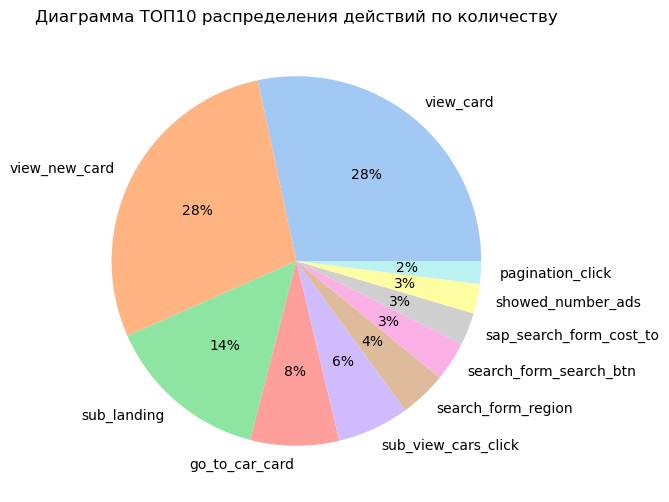

In [71]:
# диаграмма распределения большинства действий на сайте
plt.figure(figsize=(10, 6))
plt.title("Диаграмма ТОП10 распределения действий по количеству")
plt.pie(df_hits.event_action.value_counts()[:10], labels=df_hits.event_action.value_counts().index[:10],
        colors = sns.color_palette('pastel'), autopct='%.0f%%')
plt.show()

In [9]:
# подсчет общего количества событий, удовлетворяющих целевому
target = ['sub_car_claim_click', 'sub_car_claim_submit_click', 'sub_open_dialog_click', 
          'sub_custom_question_submit_click', 'sub_call_number_click', 'sub_callback_submit_click', 
          'sub_submit_success', 'sub_car_request_submit_click']

value_target = df_hits.apply(lambda x: x['event_action'] in target, axis=1).sum()

print(f'Всего действий, удовлетворяющих целевому событию: {value_target}')
print(f'Процент от общего числа {value_target / df_hits.shape[0] * 100:.4f}')

Всего действий, удовлетворяющих целевому событию: 104908
Процент от общего числа 0.6671


In [10]:
# просмотр целевых событий по каждому действию

for tar in target:
    value = df_hits[df_hits['event_action'] == tar].shape[0]
    print(f'{tar} --- {value} процент от общего {value / df_hits.shape[0] * 100:.4f}')

sub_car_claim_click --- 37928 процент от общего 0.2412
sub_car_claim_submit_click --- 12359 процент от общего 0.0786
sub_open_dialog_click --- 25870 процент от общего 0.1645
sub_custom_question_submit_click --- 619 процент от общего 0.0039
sub_call_number_click --- 3653 процент от общего 0.0232
sub_callback_submit_click --- 3074 процент от общего 0.0195
sub_submit_success --- 18439 процент от общего 0.1172
sub_car_request_submit_click --- 2966 процент от общего 0.0189


In [11]:
# на основе event_action создам новый признак target_action
# 1 если действие входит в target
df_hits['target_action'] = df_hits.apply(lambda x: 1 if x['event_action'] in target  else 0, axis=1)
df_hits.target_action.value_counts()

target_action
0    15621562
1      104908
Name: count, dtype: int64

#### Обработка значений в столбце hit_page_path

In [12]:
# hit_page_path содерижит информацию про марку и модель авто
# просмотр 10 первых записей
for i in range(10):
    print(df_hits.hit_page_path.iloc[i], '\n')

sberauto.com/cars?utm_source_initial=google&utm_medium_initial=cpc&utm_campaign_initial=bJJuEXRheRIxXEaYIXqM|BmWKiKCvBVipoWOpNUIL&utm_content_initial=yXzSAJWSuRbYeLFyMVFl|iJxXDTgPAXGQYOdgCzqe|xAEYTlJDbQNwQTLGxICQ|pmvTbUlmnwAkuHIbvKUg|lFpAoUqEvHoyZfCNRuCR|oxjYxrkwnRSTTYcVZzdb|dtYJKUplNmmKCOfiziff|NgTCwCMgdzcCqxiALuwY|aHSPdWXGkJravzWuwcJA|HbolMJUevblAbkHClEQa|kqZPVvZmXADsCZxIQwbv|QaGunexmXrztCWbLcYxs|OfdDOXSwHYclonQJpPxh|htxLmqvAkmISCliXGMzb|HbolMJUevblAbkHClEQa&utm_term_initial=&city=1&rental_page=rental_only&rental_car=rental_only&city=18 

sberauto.com/cars/fiat?city=1&city=18&rental_car=rental_only&utm_source_initial=sbol&utm_medium_initial=banner&utm_campaign_initial=zxoiLxhuSIFrCeTLQVWZ&rental_page=rental_only 

sberauto.com/cars/all/volkswagen/polo/e994838f?utm_source_initial=yandex&utm_medium_initial=cpc&utm_campaign_initial=nSReTmyFtbSjlPrTKoaX|fVHJqnfOFSWcsCBViJGr&utm_content_initial=yXzSAJWSuRbYeLFyMVFl|YjagTPsykUtMSrHgFPJc|xAEYTlJDbQNwQTLGxICQ|dwfnIkMEwJhmnyojmAoc|lFpAoUqEvHo

In [13]:
# добавлю модель и марку авто к датасету
df_hits[['manufacturer_car', 'model_car']] = df_hits.hit_page_path.str.split('/', expand=True)[[3, 4]]
df_hits.head(10)

,session_id,hit_date,hit_time,hit_number,hit_type,hit_referer,hit_page_path,event_category,event_action,event_label,event_value,target_action,manufacturer_car,model_car
0,5639623078712724064.1640254056.1640254056,2021-12-23,597864.0,30,event,NaN,sberauto.com/cars?utm_source_initial=google&ut...,quiz,quiz_show,NaN,NaN,0,None,None
1,7750352294969115059.1640271109.1640271109,2021-12-23,597331.0,41,event,NaN,sberauto.com/cars/fiat?city=1&city=18&rental_c...,quiz,quiz_show,NaN,NaN,0,None,None
2,885342191847998240.1640235807.1640235807,2021-12-23,796252.0,49,event,NaN,sberauto.com/cars/all/volkswagen/polo/e994838f...,quiz,quiz_show,NaN,NaN,0,volkswagen,polo
3,142526202120934167.1640211014.1640211014,2021-12-23,934292.0,46,event,NaN,sberauto.com/cars?utm_source_initial=yandex&ut...,quiz,quiz_show,NaN,NaN,0,None,None
4,3450086108837475701.1640265078.1640265078,2021-12-23,768741.0,79,event,NaN,sberauto.com/cars/all/mercedes-benz/cla-klasse...,quiz,quiz_show,NaN,NaN,0,mercedes-benz,cla-klasse
5,6466333295973247896.1640246168.1640246168,2021-12-23,704194.0,41,event,NaN,sberauto.com/cars?utm_source_initial=youtube&u...,quiz,quiz_show,NaN,NaN,0,None,None
6,281215510786615563.1640245516.1640245516,2021-12-23,911854.0,102,event,NaN,sberauto.com/cars/toyota?isnew=false&rental_ca...,quiz,quiz_show,NaN,NaN,0,None,None
7,4024492994895054107.1640269084.1640269084,2021-12-23,1071804.0,85,event,NaN,sberauto.com/cars/all/mercedes-benz/glc/f8f330...,quiz,quiz_show,NaN,NaN,0,mercedes-benz,glc
8,555009234841130092.1640256620.1640256620,2021-12-23,1013899.0,101,event,VloVXNWduHeTjUoDkjkO,sberauto.com/cars/all/kia/sorento/c38179cb?utm...,quiz,quiz_show,NaN,NaN,0,kia,sorento
9,2692901778487480807.1640206845.1640206845,2021-12-23,0.0,1,event,NaN,sberauto.com/cars/all/nissan/x-trail/0744675f?...,card_web,view_card,NaN,NaN,0,nissan,x-trail


In [14]:
# просмотр ТОП20 популярных значений по автомобилям
df_hits[['manufacturer_car', 'model_car']].value_counts()[:20]

manufacturer_car  model_car 
skoda             rapid         442513
lada-vaz          vesta         403910
volkswagen        polo          318075
skoda             karoq         194273
mercedes-benz     e-klasse      178467
nissan            qashqai       153153
kia               rio            90249
nissan            x-trail        85548
skoda             octavia        77005
renault           duster         76676
toyota            camry          73149
renault           logan          72088
kia               seltos         70464
                  sorento        69886
volkswagen        tiguan         62101
mercedes-benz     glb            61043
                  gla-klasse     55236
volvo             s90            51627
haval             jolion         51538
bmw               5-serii        40453
Name: count, dtype: int64

In [15]:
# в список производителй попали также некорректные данные,
# где не указана модель авто, отфильттрую их
name_auto = ['volvo', 'kia', 'lada-vaz', 'honda', 'mini', 'lexus', 'land-rover', 'renault', 'porsche', 'bmw', 'hyundai', 'chery', 
             'mitsubishi', 'nissan', 'mercedes-benz', 'chevrolet', 'jeep',
             'haval', 'skoda', 'toyota', 'audi', 'peugeot', 'volkswagen']

# сделаю замену среди производителей не вошедших в name_avto на 0

df_hits['manufacturer_car'] = df_hits.apply(lambda x: 0 if x['manufacturer_car'] not in name_auto else x['manufacturer_car'], axis=1)

In [16]:
df_hits['manufacturer_car'].value_counts(dropna=False)

manufacturer_car
0                12308700
skoda              744834
mercedes-benz      472559
volkswagen         417360
lada-vaz           404196
nissan             238870
kia                236707
bmw                195598
toyota             161139
renault            150757
porsche             63586
lexus               61631
audi                60186
volvo               51687
haval               51550
mini                34709
peugeot             27450
land-rover          24891
hyundai             19309
honda                 467
mitsubishi            150
chery                  78
jeep                   31
chevrolet              25
Name: count, dtype: int64

In [17]:
# из оствашихся значений выберу марку авттомобиля
df_hits['model_car'] = df_hits.apply(lambda x: 0 if pd.isna(x['model_car']) else x['model_car'].split('?')[0], axis=1)

In [18]:
# популярные марки автомобилей
model_auto = ['cayenne', 'ceed',  'cerato', 'civic-type-r', 'cla-klasse', 'corolla', 'creta', 'crown', 'defender', 'duster', 'e-klasse', 'e-tron',
              'fortuner',  'g-klasse', 'gla-klasse', 'glb', 'glc', 'gle', 'gls-klasse', 'granta',  'jolion', 'k5', 'karoq', 'kodiaq', 
              'land-cruiser-prado', 'largus', 'logan', 'macan', 'megane', 'nx', 'octavia', 'outlander', 'panamera', 'passat', 'passat-cc', 
              'polo', 'q5', 'qashqai', 'qx60', 'range-rover', 'range-rover-velar', 'rapid', 'rav-4', 'rio', 'rx', 's-klasse', 's90',  'seltos',
              'solaris', 'sorento', 'soul', 'sportage', 'taos', 'teramont', 'tiggo-8', 'tiguan', 'touareg', 'traveller', 'vesta', 'hatch',  'x-trail', 
              'x1', 'x3', 'x3-m', 'x4-m', 'x5', 'x6', 'x7', 'xc90', '2-serii', '2112', '3-serii', '5-serii',  '7-serii',  '911', 'a3', 'a4',
              'a8', 'accord', 'alphard', 'arkana', 'asx', 'c-klasse', 'camry']

# сделаю замену значений по популярным маркам автомобиля
df_hits['model_car'] = df_hits.apply(lambda x: 0 if x['model_car'] not in model_auto or x['manufacturer_car'] == 0 else x['model_car'], axis=1)

In [19]:
#посмотрю еще раз ТОП20 популярных значений по автомобилям
df_hits[['manufacturer_car', 'model_car']].value_counts(dropna=False)[:20]

manufacturer_car  model_car 
0                 0             12308700
skoda             rapid           442579
lada-vaz          vesta           403994
volkswagen        polo            318146
skoda             karoq           194291
mercedes-benz     e-klasse        178475
nissan            qashqai         153169
kia               rio              90299
nissan            x-trail          85595
skoda             octavia          77197
renault           duster           76687
toyota            camry            73243
renault           logan            72121
kia               seltos           70498
                  sorento          69937
volkswagen        tiguan           62124
mercedes-benz     glb              61045
                  gla-klasse       55299
volvo             s90              51627
haval             jolion           51540
Name: count, dtype: int64

#### Объединение df_hits и df_session в общий датасет

In [20]:
# сделаю группировку по 'target_action' для session_id
# при наличии целевого дейиствия за одну сессию возвращает True
target_action = df_hits.groupby('session_id')['target_action'].any().astype(int)
target_action.sample(5)

session_id
7667088186355245622.1632396489.1632396489    0
4920574858200096610.1639711518.1639711518    0
8218067297116270482.1625206625.1625206625    0
3020395753512156945.1630584518.1630584518    0
198445211741787907.1631524652.1631524652     0
Name: target_action, dtype: int32

In [21]:
# процент целевого действия за одну сессию
target_action.value_counts() /  target_action.shape[0] * 100

target_action
0    97.073694
1     2.926306
Name: count, dtype: float64

#### Загрузка данных и обьединение

In [22]:
# зарузка ga_sessions_features.csv

df_sessions = pd.read_csv('data/ga_sessions_features.csv', low_memory=False)
df_sessions.head()

,session_id,client_id,visit_date,visit_time,visit_number,utm_source,utm_medium,utm_campaign,utm_adcontent,device_category,...,device_browser,geo_country,geo_city,day_of_the_week,quarter_of_the_year,viewing_time,advert_social_media,organic_traffic,visit_big_city,moskow_area
0,9055434745589932991.1637753792.1637753792,2108382700.1637753791,2021-11-24,14:36:32,1,ZpYIoDJMcFzVoPFsHGJL,banner,LEoPHuyFvzoNfnzGgfcd,vCIpmpaGBnIQhyYNkXqp,mobile,...,Chrome,Russia,Zlatoust,Wednesday,4,day,0,0,0,0
1,905544597018549464.1636867290.1636867290,210838531.1636867288,2021-11-14,08:21:30,1,MvfHsxITijuriZxsqZqt,cpm,FTjNLDyTrXaWYgZymFkV,xhoenQgDQsgfEPYNPwKO,mobile,...,Samsung Internet,Russia,Moscow,Sunday,4,morning,0,0,1,0
2,9055446045651783499.1640648526.1640648526,2108385331.1640648523,2021-12-28,02:42:06,1,ZpYIoDJMcFzVoPFsHGJL,banner,LEoPHuyFvzoNfnzGgfcd,vCIpmpaGBnIQhyYNkXqp,mobile,...,Chrome,Russia,Krasnoyarsk,Tuesday,4,night,0,0,0,0
3,9055447046360770272.1622255328.1622255328,2108385564.1622255328,2021-05-29,05:00:00,1,kjsLglQLzykiRbcDiGcD,cpc,gecBYcKZCPMcVYdSSzKP,other_content,mobile,...,Chrome,Russia,Moscow,Saturday,2,night,0,0,1,0
4,9055447046360770272.1622255345.1622255345,2108385564.1622255328,2021-05-29,05:00:00,2,kjsLglQLzykiRbcDiGcD,cpc,gecBYcKZCPMcVYdSSzKP,other_content,mobile,...,Chrome,Russia,Moscow,Saturday,2,night,0,0,1,0


In [23]:
# добавлю target_action и сохрню в новый датафрейм 
df_full = pd.merge(left=df_sessions, right=target_action, on='session_id', how='inner')
df_full.head()

,session_id,client_id,visit_date,visit_time,visit_number,utm_source,utm_medium,utm_campaign,utm_adcontent,device_category,...,geo_country,geo_city,day_of_the_week,quarter_of_the_year,viewing_time,advert_social_media,organic_traffic,visit_big_city,moskow_area,target_action
0,9055434745589932991.1637753792.1637753792,2108382700.1637753791,2021-11-24,14:36:32,1,ZpYIoDJMcFzVoPFsHGJL,banner,LEoPHuyFvzoNfnzGgfcd,vCIpmpaGBnIQhyYNkXqp,mobile,...,Russia,Zlatoust,Wednesday,4,day,0,0,0,0,0
1,905544597018549464.1636867290.1636867290,210838531.1636867288,2021-11-14,08:21:30,1,MvfHsxITijuriZxsqZqt,cpm,FTjNLDyTrXaWYgZymFkV,xhoenQgDQsgfEPYNPwKO,mobile,...,Russia,Moscow,Sunday,4,morning,0,0,1,0,0
2,9055446045651783499.1640648526.1640648526,2108385331.1640648523,2021-12-28,02:42:06,1,ZpYIoDJMcFzVoPFsHGJL,banner,LEoPHuyFvzoNfnzGgfcd,vCIpmpaGBnIQhyYNkXqp,mobile,...,Russia,Krasnoyarsk,Tuesday,4,night,0,0,0,0,0
3,9055447046360770272.1622255328.1622255328,2108385564.1622255328,2021-05-29,05:00:00,1,kjsLglQLzykiRbcDiGcD,cpc,gecBYcKZCPMcVYdSSzKP,other_content,mobile,...,Russia,Moscow,Saturday,2,night,0,0,1,0,0
4,9055447046360770272.1622255345.1622255345,2108385564.1622255328,2021-05-29,05:00:00,2,kjsLglQLzykiRbcDiGcD,cpc,gecBYcKZCPMcVYdSSzKP,other_content,mobile,...,Russia,Moscow,Saturday,2,night,0,0,1,0,0


In [24]:
# получившийся общий датафрейм размером
df_full.shape

(1732266, 24)

In [25]:
# проверка на пропуски
df_full.isna().sum()

session_id                  0
client_id                   0
visit_date                  0
visit_time                  0
visit_number                0
utm_source                  0
utm_medium                  0
utm_campaign                0
utm_adcontent               0
device_category             0
device_os                   0
device_brand                0
device_screen_resolution    0
device_browser              0
geo_country                 0
geo_city                    0
day_of_the_week             0
quarter_of_the_year         0
viewing_time                0
advert_social_media         0
organic_traffic             0
visit_big_city              0
moskow_area                 0
target_action               0
dtype: int64

In [26]:
# сохраню в файл датафрейм
df_full.to_csv('data/ga_df_full.csv', index=False)

In [27]:
## Загрузка данных, для предобработки

In [28]:
df_full = pd.read_csv('data/ga_df_full.csv', low_memory=False )

In [29]:
# удалю некоторые  исходные признаки чтобы не было корреляции
# 'session_id',
columns_on_drop = [ 'client_id', 'visit_number', 'visit_date', 'visit_time', 'utm_source', 'utm_medium',
                   'device_screen_resolution', 'geo_city']
df_full.drop(columns=columns_on_drop, inplace=True)

In [30]:
df_full.head()

,session_id,utm_campaign,utm_adcontent,device_category,device_os,device_brand,device_browser,geo_country,day_of_the_week,quarter_of_the_year,viewing_time,advert_social_media,organic_traffic,visit_big_city,moskow_area,target_action
0,9055434745589932991.1637753792.1637753792,LEoPHuyFvzoNfnzGgfcd,vCIpmpaGBnIQhyYNkXqp,mobile,Android,Huawei,Chrome,Russia,Wednesday,4,day,0,0,0,0,0
1,905544597018549464.1636867290.1636867290,FTjNLDyTrXaWYgZymFkV,xhoenQgDQsgfEPYNPwKO,mobile,Android,Samsung,Samsung Internet,Russia,Sunday,4,morning,0,0,1,0,0
2,9055446045651783499.1640648526.1640648526,LEoPHuyFvzoNfnzGgfcd,vCIpmpaGBnIQhyYNkXqp,mobile,Android,Huawei,Chrome,Russia,Tuesday,4,night,0,0,0,0,0
3,9055447046360770272.1622255328.1622255328,gecBYcKZCPMcVYdSSzKP,other_content,mobile,Android,Xiaomi,Chrome,Russia,Saturday,2,night,0,0,1,0,0
4,9055447046360770272.1622255345.1622255345,gecBYcKZCPMcVYdSSzKP,other_content,mobile,Android,Xiaomi,Chrome,Russia,Saturday,2,night,0,0,1,0,0


In [37]:
df_full.columns

Index(['session_id', 'utm_campaign', 'utm_adcontent', 'device_category',
       'device_os', 'device_brand', 'device_browser', 'geo_country',
       'day_of_the_week', 'quarter_of_the_year', 'viewing_time',
       'advert_social_media', 'organic_traffic', 'visit_big_city',
       'moskow_area', 'target_action'],
      dtype='object')

In [31]:
# # сохраню преобработанный в файл датафрейм для моделирования
df_full.to_csv('data/ga_full.csv', index=False)

In [32]:
# просмотр типов данных
df_full.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1732266 entries, 0 to 1732265
Data columns (total 16 columns):
 #   Column               Dtype 
---  ------               ----- 
 0   session_id           object
 1   utm_campaign         object
 2   utm_adcontent        object
 3   device_category      object
 4   device_os            object
 5   device_brand         object
 6   device_browser       object
 7   geo_country          object
 8   day_of_the_week      object
 9   quarter_of_the_year  int64 
 10  viewing_time         object
 11  advert_social_media  int64 
 12  organic_traffic      int64 
 13  visit_big_city       int64 
 14  moskow_area          int64 
 15  target_action        int64 
dtypes: int64(6), object(10)
memory usage: 211.5+ MB


In [33]:
# просмотр количества уникальных значений в данных
for col in df_full.columns:
    print(col, df_full[col].nunique())

session_id 1732266
utm_campaign 5
utm_adcontent 5
device_category 3
device_os 7
device_brand 5
device_browser 9
geo_country 2
day_of_the_week 7
quarter_of_the_year 3
viewing_time 4
advert_social_media 2
organic_traffic 2
visit_big_city 2
moskow_area 2
target_action 2


In [34]:
df_full.duplicated().sum()

0

In [35]:
df_full.shape

(1732266, 16)